# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11286636129052309838
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1694757803786910309
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 20:30:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'InceptionV3'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 2
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1"
T_all_labels = "T0", "T1"

#base_path = ''
base_path = 'gdrive/My Drive/Research_1_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_InceptionV3_None S_InceptionV3_imagenet T_InceptionV3_None T_InceptionV3_imagenet


['S_InceptionV3_imagenet',
 'S_InceptionV3_None',
 'T_InceptionV3_imagenet',
 'T_InceptionV3_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1440, 128, 128, 3) (1440, 2)
(480, 128, 128, 3) (480, 2)
(480, 128, 128, 3) (480, 2)

(1920, 128, 128, 3) (1920, 2)
(640, 128, 128, 3) (640, 2)
(640, 128, 128, 3) (640, 2)


## 2-2. Image Check

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


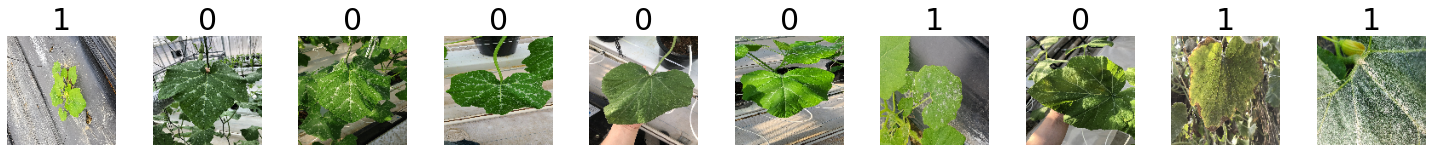

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


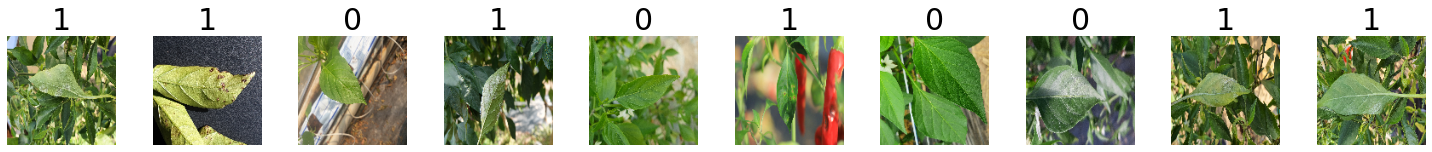

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.InceptionV3 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 20s 209ms/step - loss: 0.3115 - accuracy: 0.8667 - val_loss: 1.0680 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 116ms/step - loss: 0.1408 - accuracy: 0.9479 - val_loss: 0.7268 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 116ms/step - loss: 0.0462 - accuracy: 0.9868 - val_loss: 0.8064 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 127ms/step - loss: 0.0832 - accuracy: 0.9674 - val_loss: 0.7839 - val_accuracy: 0.5042
Epoch 5/100
23/23 [==============================] - 3s 125ms/step - loss: 0.0751 - accuracy: 0.9660 - val_loss: 6.2154 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 116ms/step - loss: 0.0356 - accuracy: 0.9924 - val_loss: 2.5641 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 3s 116ms/step - loss: 0.0891 - accuracy: 0.9660 - val_loss: 3.1102 - val_accuracy: 0.500

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.311472,0.866667,1.068027,0.500000
1,0.140773,0.947917,0.726831,0.500000
2,0.046163,0.986806,0.806359,0.500000
3,0.083191,0.967361,0.783920,0.504167
4,0.075116,0.965972,6.215420,0.500000
...,...,...,...,...
56,0.002826,0.999306,0.056275,0.985417
57,0.001347,0.999306,0.060175,0.987500
58,0.000623,1.000000,0.189131,0.975000
59,0.000163,1.000000,0.178944,0.975000


Minimum validation loss: 0.05134424939751625
Maximum validation accuracy: 0.9895833134651184


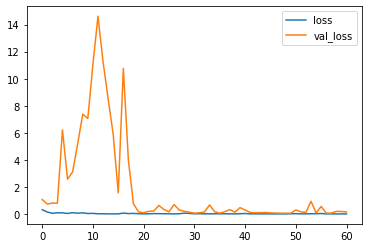

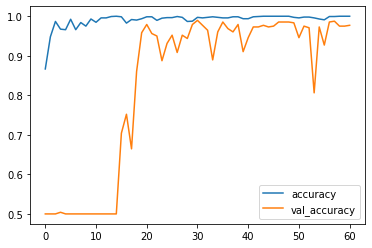

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 25ms/step - loss: 0.0496 - accuracy: 0.9875
test loss, test acc: [0.049622904509305954, 0.987500011920929]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

15/15 [==============================] - 1s 23ms/step


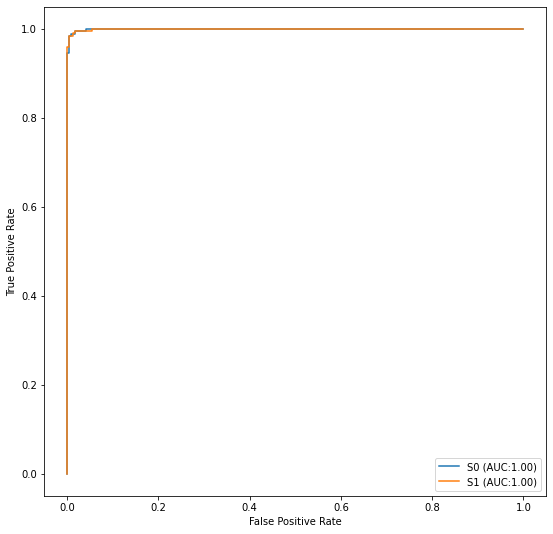

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

87924736/87910968 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 10s 180ms/step - loss: 0.3122 - accuracy: 0.8944 - val_loss: 17136.5234 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 122ms/step - loss: 0.0691 - accuracy: 0.9812 - val_loss: 1296.2557 - val_accuracy: 0.5146
Epoch 3/100
23/23 [==============================] - 3s 122ms/step - loss: 0.0355 - accuracy: 0.9903 - val_loss: 37.0304 - val_accuracy: 0.6917
Epoch 4/100
23/23 [==============================] - 3s 122ms/step - loss: 0.0361 - accuracy: 0.9951 - val_loss: 0.4210 - val_accuracy: 0.9229
Epoch 5/100
23/23 [==============================] - 3s 116ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.9332 - val_accuracy: 0.8438
Epoch 6/100
23/23 [==============================] - 3s 121ms/step - loss: 0.0184 - accuracy: 0.9958 - val_loss: 0.1381 - val_accuracy: 0.9667
Epoch 7/100
23/23 [==============================] - 3s 122ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.2004 - val_accurac

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,3.122456e-01,0.894444,17136.523438,0.500000
1,6.909265e-02,0.981250,1296.255737,0.514583
2,3.549617e-02,0.990278,37.030422,0.691667
3,3.607933e-02,0.995139,0.421042,0.922917
4,1.948460e-02,0.993750,0.933192,0.843750
5,1.844328e-02,0.995833,0.138080,0.966667
6,7.384407e-03,0.997917,0.200352,0.968750
7,2.084340e-02,0.994444,0.568031,0.947917
8,4.634491e-03,0.999306,0.212123,0.970833
9,1.562190e-02,0.994444,4.688860,0.637500


Minimum validation loss: 0.03390387073159218
Maximum validation accuracy: 0.9937499761581421


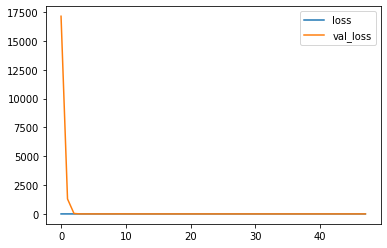

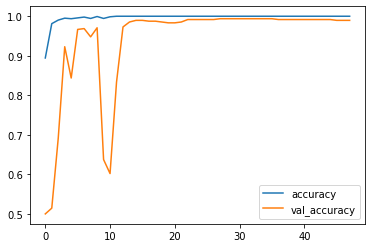

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 25ms/step - loss: 0.0195 - accuracy: 0.9958
test loss, test acc: [0.019512485712766647, 0.9958333373069763]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

15/15 [==============================] - 1s 23ms/step


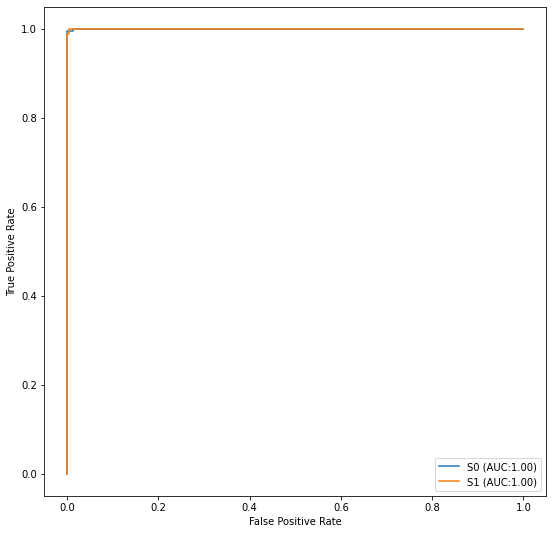

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 11s 177ms/step - loss: 0.5114 - accuracy: 0.7505 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 117ms/step - loss: 0.2903 - accuracy: 0.8823 - val_loss: 1.2958 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 3s 117ms/step - loss: 0.2097 - accuracy: 0.9323 - val_loss: 1.8070 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 4s 122ms/step - loss: 0.1648 - accuracy: 0.9380 - val_loss: 0.7017 - val_accuracy: 0.5109
Epoch 5/100
30/30 [==============================] - 4s 121ms/step - loss: 0.1621 - accuracy: 0.9359 - val_loss: 0.6710 - val_accuracy: 0.6109
Epoch 6/100
30/30 [==============================] - 4s 117ms/step - loss: 0.1134 - accuracy: 0.9552 - val_loss: 3.3394 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 4s 117ms/step - loss: 0.1688 - accuracy: 0.9307 - val_loss: 0.7850 - val_accuracy: 0.600

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.511363,0.750521,0.743319,0.500000
1,0.290276,0.882292,1.295758,0.500000
2,0.209712,0.932292,1.806950,0.500000
3,0.164836,0.938021,0.701702,0.510938
4,0.162082,0.935938,0.670951,0.610937
5,0.113387,0.955208,3.339449,0.500000
6,0.168839,0.930729,0.784967,0.600000
7,0.084841,0.971354,1.975693,0.498437
8,0.070688,0.977083,4.188094,0.500000
9,0.073304,0.974479,3.535501,0.500000


Minimum validation loss: 0.19343335926532745
Maximum validation accuracy: 0.956250011920929


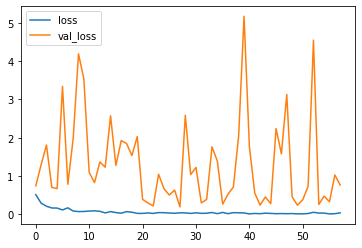

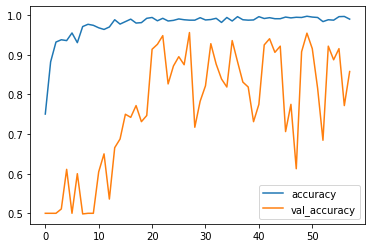

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 2s 26ms/step - loss: 0.1872 - accuracy: 0.9516
test loss, test acc: [0.18724516034126282, 0.9515625238418579]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

20/20 [==============================] - 2s 23ms/step


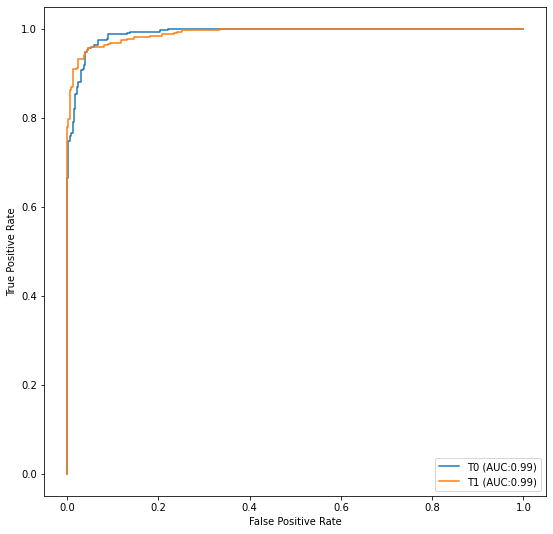

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 11s 170ms/step - loss: 0.2834 - accuracy: 0.8729 - val_loss: 14.8240 - val_accuracy: 0.5266
Epoch 2/100
30/30 [==============================] - 4s 122ms/step - loss: 0.0672 - accuracy: 0.9745 - val_loss: 5.2438 - val_accuracy: 0.6469
Epoch 3/100
30/30 [==============================] - 4s 123ms/step - loss: 0.0570 - accuracy: 0.9823 - val_loss: 4.8145 - val_accuracy: 0.6922
Epoch 4/100
30/30 [==============================] - 4s 122ms/step - loss: 0.0459 - accuracy: 0.9901 - val_loss: 2.5426 - val_accuracy: 0.7953
Epoch 5/100
30/30 [==============================] - 4s 122ms/step - loss: 0.0732 - accuracy: 0.9828 - val_loss: 0.3867 - val_accuracy: 0.8297
Epoch 6/100
30/30 [==============================] - 4s 117ms/step - loss: 0.0799 - accuracy: 0.9703 - val_loss: 12.2636 - val_accuracy: 0.5141
Epoch 7/100
30/30 [==============================] - 4s 121ms/step - loss: 0.0199 - accuracy: 0.9932 - val_loss: 1.8709 - val_accuracy: 0.9

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.283443,0.872917,14.823959,0.526563
1,0.067246,0.974479,5.243804,0.646875
2,0.057050,0.982292,4.814546,0.692187
3,0.045895,0.990104,2.542568,0.795313
4,0.073199,0.982813,0.386726,0.829687
5,0.079884,0.970312,12.263593,0.514063
6,0.019875,0.993229,1.870872,0.959375
7,0.046247,0.987500,0.200901,0.923437
8,0.029151,0.991667,1.039253,0.823438
9,0.034405,0.990104,0.222663,0.950000


Minimum validation loss: 0.011941572651267052
Maximum validation accuracy: 0.996874988079071


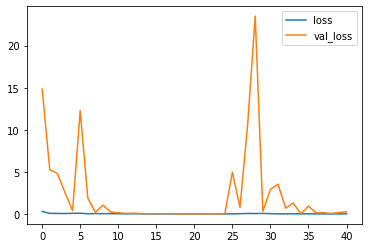

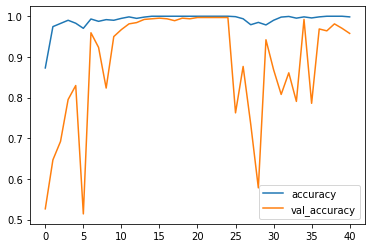

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 2s 25ms/step - loss: 0.0407 - accuracy: 0.9937
test loss, test acc: [0.04070684686303139, 0.9937499761581421]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

20/20 [==============================] - 1s 23ms/step


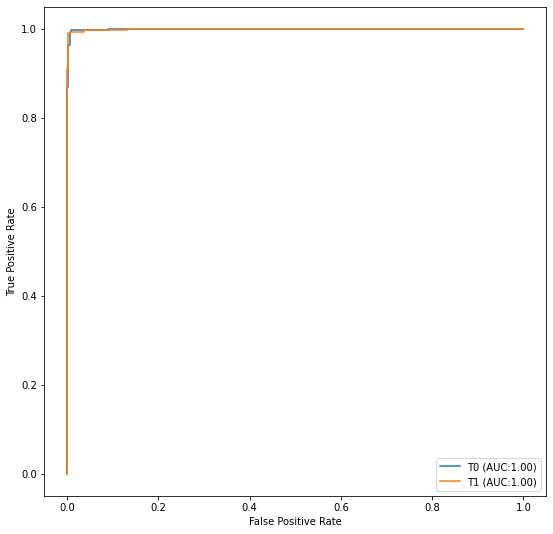

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_InceptionV3_None
test loss, test acc: [0.049622904509305954, 0.987500011920929]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_InceptionV3_imagenet
test loss, test acc: [0.019512485712766647, 0.9958333373069763]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_InceptionV3_None
test loss, test acc: [0.18724516034126282, 0.9515625238418579]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_InceptionV3_imagenet
test loss, test acc: [0.04070684686303139, 0.9937499761581421]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_InceptionV3_None →→→ Target Test
20/20 [==============================] - 1s 25ms/step - loss: 2.6899 - accuracy: 0.6594
test loss, test acc: [2.689889430999756, 0.659375011920929]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_InceptionV3_imagenet →→→ Target Test
20/20 [==============================] - 1s 26ms/step - loss: 3.2110 - accuracy: 0.6375
test loss, test acc: [3.2110328674316406, 0.637499988079071]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_InceptionV3_None →→→ Source Test
15/15 [==============================] - 0s 25ms/step - loss: 5.0354 - accuracy: 0.6083
test loss, test acc: [5.035445690155029, 0.6083333492279053]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_InceptionV3_imagenet →→→ Source Test
15/15 [==============================] - 0s 26ms/step - loss: 1.9147 - accuracy: 0.6687
test loss, test acc: [1.9146575927734375, 0.668749988079071]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )